# Test on synthetic data

We evaluate the performance of the gridder on synthetic data produced by a visco-elastic model of the San Andreas Fault. We extract random samples from the model grid and try to reconstruct the original grid using our interpolation method. We include a region with denser sampling around the sourther portion of the fault to simulate real world data, which is irregularly sampled.

In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client
import itertools
import verde as vd
# Load our custom gridder and utility functions
from vectorspline3d import VectorSpline3D
from vectorspline3d.utils import sample_from_grid

## Load the 3-component synthetic grid

The synthetic grid is stored in a netCDF file with all 3 components included. This grid is a subsection of the original model data.

In [2]:
grid = xr.open_dataset("../../data/synthetic-san-andreas-2017.nc")
print(grid)

<xarray.Dataset>
Dimensions:         (easting: 180, northing: 360)
Coordinates:
  * easting         (easting) float64 300.2 302.8 305.2 ... 742.8 745.2 747.8
  * northing        (northing) float64 100.2 102.8 105.2 ... 992.8 995.2 997.8
Data variables:
    east_velocity   (northing, easting) float32 ...
    north_velocity  (northing, easting) float32 ...
    up_velocity     (northing, easting) float32 ...
Attributes:
    Conventions:  COARDS, CF-1.5
    title:        Produced by grdcut
    history:      grdcut xvel_2017.grd -Gxvel_2017c.grd -R0/1000/0/1700
    description:  
    GMT_version:  5.4.2 (r18461) [64-bit]
    node_offset:  1


Extract some useful values from the grid, like grid spacing, region, and coordinates. We'll use these values later on.

In [3]:
region = vd.get_region((grid.easting, grid.northing))
spacing = (grid.easting.values[1] - grid.easting.values[0], 
           grid.northing.values[1] - grid.northing.values[0])
print(spacing)

(2.5, 2.5)


Create a function that plots our grid with vectors for the horizontal components and a pseudo-color map for the vertical.

In [4]:
def plot_data(data, ax=None, maxabs=3, every_arrow=4, quiver_scale=250, quiver_width=0.0015, size=50):
    "Plot a grid or a DataFrame with the vertical in color and horizontal as vectors."
    if ax is None:
        plt.figure(figsize=(6, 15))
        ax = plt.subplot(111)
    cbargs = dict(orientation="horizontal", aspect=50, pad=0.05, label="vertical velocity (mm/yr)",
                  shrink=0.8)
    if isinstance(data, pd.DataFrame):
        tmp = ax.scatter(data.easting, data.northing, s=size, c=data.up_velocity,
                         vmin=-maxabs, vmax=maxabs, cmap="seismic")
        plt.colorbar(tmp, ax=ax, **cbargs)        
    else:
        data.up_velocity.plot.pcolormesh(ax=ax, vmin=-maxabs, vmax=maxabs, cmap="seismic",
                                         cbar_kwargs=cbargs)
        indexer = slice(None, None, every_arrow)
        # Downsample the arrows so we can actually see something
        data = data.isel(easting=indexer, northing=indexer)
    ax.quiver(data.easting, data.northing, data.east_velocity, data.north_velocity, 
              scale=quiver_scale, width=quiver_width)
    ax.set_aspect("equal")
    ax.set_xlabel("x (km)")
    ax.set_ylabel("y (km)")
    return ax

Plot the synthetic grid.

Text(0.5, 1.0, 'Synthetic data')

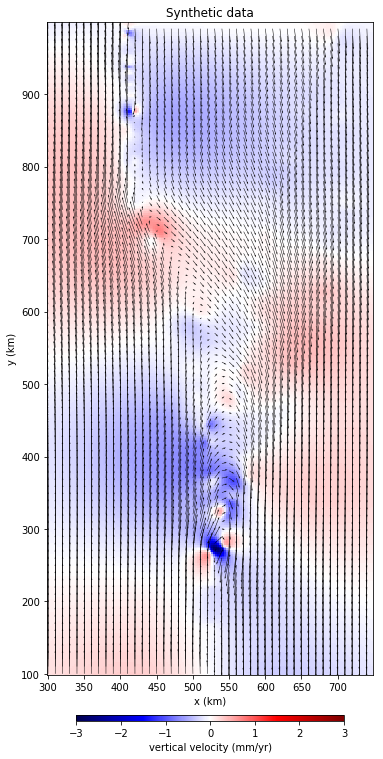

In [5]:
plot_data(grid).set_title("Synthetic data")

## Extract random samples

We'll test our gridder on random samples extracted from the synthetic grid.

In [6]:
ndata = 3000
ncoarse = 1200
nfine = ndata - ncoarse
# First take a coarse sample
coarse = sample_from_grid(grid, size=ncoarse, random_state=0)
# and now a finner sample from a smaller section of the grid
fine = sample_from_grid(
    grid.sel(easting=slice(480, 600), northing=slice(None, 600)), 
    size=nfine, 
    random_state=0
)
data = pd.concat([coarse, fine])
data.head()

,east_velocity,north_velocity,up_velocity,easting,northing
0,-0.411302,-19.127003,0.080961,730.25,247.75
1,-5.034731,14.066132,0.442719,417.75,717.75
2,-0.410284,-19.725784,-0.252692,592.75,117.75
3,1.150378,-8.158042,-0.412053,467.75,820.25
4,3.667027,-5.900506,0.019311,557.75,630.25


Text(0.5, 1.0, 'Synthetic samples')

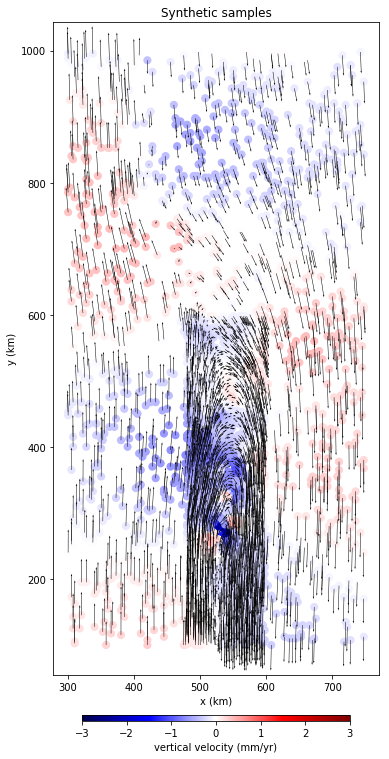

In [7]:
plot_data(data).set_title("Synthetic samples")

## Fit the 3 component spline

We'll do a grid-search for the best configuration by optimizing the R² score on the original gridded data.

A challenge is where to place the forces. Traditionally, forces are placed beneath each data point. This can lead to aliasing unless the data is first decimated using a blocked mean/median. What we can do instead is to use a blocked mean to determine force positions and number and keep the full dataset for fitting. The spacing for the blocked mean is the final desired spacing for our grid.

In [8]:
# We don't care about the blocked quantity, just the coordinates.
blockmean = vd.BlockReduce(reduction=np.mean, spacing=spacing, center_coordinates=True)
force_coords, _ = blockmean.filter((data.easting, data.northing), np.ones(ndata))

Another issue is with the different magnitudes of each data component.

In [9]:
print(np.linalg.norm(data.up_velocity)/np.linalg.norm(data.east_velocity))

0.15494496


This means that an unweighted fit will favor the horizontal components at the expense of the vertical. We can use data weights to balance things out and make sure that the vertical is fitted as well.

In [10]:
weights = (np.full(ndata, 0.0001), np.full(ndata, 0.0001), np.full(ndata, 1.0))

Our training data set will be randomly sampled set and the testing set will be original grid data.

In [11]:
train = (
    (data.easting, data.northing), 
    (data.east_velocity, data.north_velocity, data.up_velocity), 
    weights
)
# We need the underlying numpy arrays ("values") because the computational core (numba) 
# doesn't play well with xarray.DataArray.
test = (
    np.meshgrid(grid.easting, grid.northing),
    (grid.east_velocity.values, grid.north_velocity.values, grid.up_velocity.values)
)

This is the parameter grid that we'll use to search for optimal configuration.

In [12]:
dampings = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
depths = [5, 10, 20, 30, 40, 50, 100]
poissons = [-1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

#dampings = [1e-2, 1e-1]
#depths = [30]
#poissons = [0.3, 0.5]

# Use itertools to create a list with all combinations of parameters to test
parameters = list(itertools.product(dampings, depths, poissons))
print("Number of combinations:", len(parameters))

Number of combinations: 343


Now we can submit a job to the parallel queue for each parameter combination and gather the R² scores.


In [14]:
%%time
scores = []
for damping, depth, poisson in parameters:
    candidate = VectorSpline3D(poisson=poisson, depth=depth, damping=damping, force_coords=force_coords)
    scores.append(candidate.fit(*train).score(*test))
best = np.argmax(scores)
best_parameters = dict(
    damping=parameters[best][0], 
    depth=parameters[best][1], 
    poisson=parameters[best][2], 
)
print("Best score on testing set:", scores[best])
print("Best parameters:", best_parameters)

Best score on testing set: 0.9760259283631793
Best parameters: {'damping': 0.001, 'depth': 50, 'poisson': 0.5}
CPU times: user 6h 59min 36s, sys: 22min 47s, total: 7h 22min 24s
Wall time: 1h 9min 36s


Fit the spline on the test configuration and score it on the training data to see how well it fit.

In [15]:
%%time
spline = VectorSpline3D(force_coords=force_coords, **best_parameters)
spline.fit(*train)
print("Score on training set:", spline.score(*test))

Score on training set: 0.9760259283631793
CPU times: user 1min 11s, sys: 3.87 s, total: 1min 14s
Wall time: 12 s


## Regenerate the original grid

Now we can recreate the original grid and calculate and plot the differences.

In [16]:
grid_spl = spline.grid(
    spacing=spacing, 
    data_names=["east_velocity", "north_velocity", "up_velocity"]
)

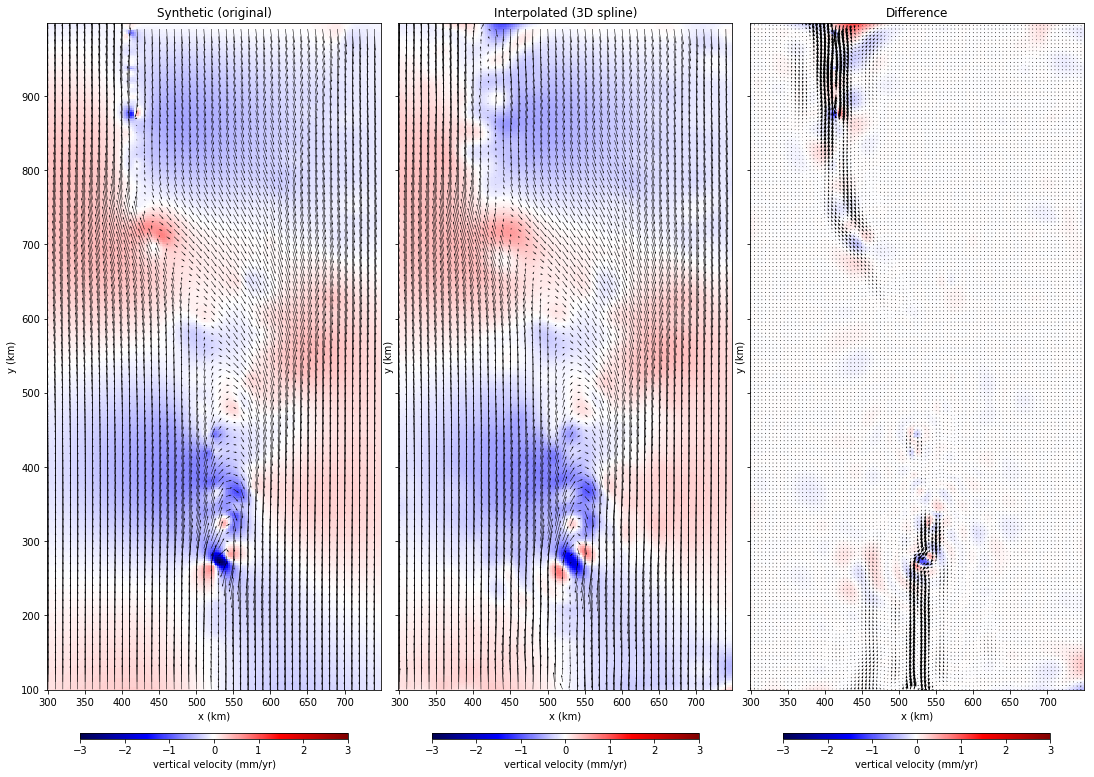

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 12), sharey=True)
plot_data(grid, ax=axes[0]).set_title("Synthetic (original)")
plot_data(grid_spl, ax=axes[1]).set_title("Interpolated (3D spline)")
plot_data(grid - grid_spl, ax=axes[2], quiver_width=0.003, every_arrow=2).set_title("Difference")
plt.tight_layout(pad=0)

Notice that the biggest difference is along the fault where there is a sharper variation on the velocity. The region with denser data coverage is less affected by this, as expected.